## Packets

In [14]:
from GraphSageModel import GNN7L_Sage
from GNNTrain import predict_from_saved_model
from CreateDataset import get_dataset_from_graph
from Paths import PATH_TO_GRAPHS, PATH_TO_MODELS, PATH_TO_RANKINGS

import heapq
import pandas as pd
import networkx as nx
from tqdm.notebook import tqdm

import torch
import torch_geometric
from torch_geometric.nn.models import GNNExplainer

torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)
print(device)

1.11.0
cuda


## Prediction

In [36]:
disease_Id = 'C0376358'
graph_path = PATH_TO_GRAPHS + 'grafo_nedbit_' + disease_Id + '.gml'

dataset = get_dataset_from_graph(graph_path, disease_Id).to(device)

[+] Reading graph...ok
[+] Creating dataset...ok
[i] Elapsed time: 40.872


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        91
           1       0.95      0.98      0.96       719
           2       0.93      0.91      0.92       718
           3       0.85      0.89      0.87       718
           4       0.94      0.88      0.91       718

    accuracy                           0.92      2964
   macro avg       0.92      0.92      0.92      2964
weighted avg       0.92      0.92      0.92      2964



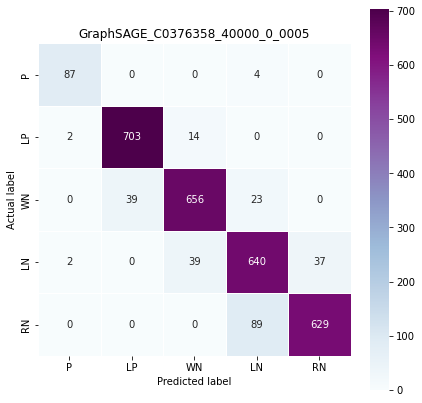

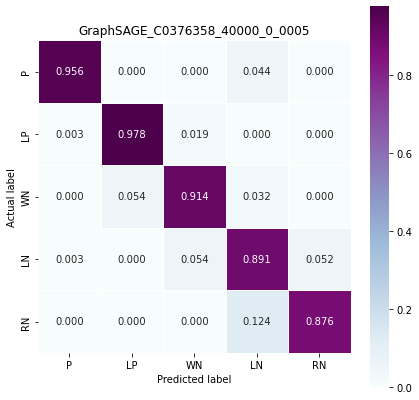

In [37]:
model_name  = 'GraphSAGE_' + disease_Id + '_40000_0_0005'
classes     = ['P', 'LP', 'WN', 'LN', 'RN']

sage_pred_multi, sage_prob_multi, sage_model = predict_from_saved_model(model_name, dataset, classes, save_to_file=False)

# Explainabilty

In [38]:
G = nx.read_gml(graph_path)

In [39]:
# Predicted P(ositive) genes in the test mask
# dictionaries with {gene: prob}
test_P      = {}
overall_LP  = {}

test_mask = dataset.test_mask
test_preds = sage_pred_multi[test_mask]
test_probs = sage_prob_multi[test_mask]

test_nodes = []
i = 0
for node in G.nodes:
    if test_mask[i]:
        test_nodes.append(node)
    if sage_pred_multi[i] == 1 and node not in overall_LP:
        overall_LP[node] = sage_prob_multi[i][1].item() # take probability of class 1 (LP)
    i += 1

i = 0
for node in test_nodes:
    if test_preds[i] == 0 and node not in test_P: #P
        test_P[node] = test_probs[i][0].item() # take probability of class 0 (p)
    i += 1

print('# of predicted positive genes in test mask:', len(test_P))
print('# of predicted overall likely positive genes:', len(overall_LP))

# of predicted positive genes in test mask: 91
# of predicted overall likely positive genes: 4975


In [40]:
k_test_positive_genes   = 20
k_explanation_nodes     = 1

top_k_test_P = heapq.nlargest(k_test_positive_genes, test_P, key=test_P.get)

# list of positive genes indexes in test_mask
top_k_test_P_idx = []

for node in top_k_test_P:
    i = 0
    for n in G.nodes:
        if node == n:
            top_k_test_P_idx.append(i)
            break
        i += 1

edge_index = dataset.edge_index

# dict to store for each index the number of nodes (pos 0)
# and edges (pos 1) in the subgraph
subg_numnodes_d = {}

for i in top_k_test_P_idx:
    subg_nodes, subg_edge_index, subg_mapping, subg_edge_mask = torch_geometric.utils.k_hop_subgraph(i, 1, edge_index)
    if i not in subg_numnodes_d:
        subg_numnodes_d[i] = [len(subg_nodes), subg_edge_index.shape[1]]

# subg_numnodes_d

### 1 Hop

In [41]:
x = dataset.x
y = dataset.y
edge_index = dataset.edge_index

candidates = {}

for i in tqdm(range(len(top_k_test_P_idx))):
    nodes_names = list(G.nodes)

    idx = top_k_test_P_idx[i]
    idx_name = nodes_names[idx]
    candidates[idx_name] = {}

    mean_mask = torch.zeros(edge_index.shape[1]).to('cpu')

    for i in tqdm(range(10)):
        explainer = GNNExplainer(sage_model, epochs=200, return_type='log_prob', num_hops=1, log=False)
        node_feat_mask, edge_mask = explainer.explain_node(idx, x, edge_index)
        mean_mask += edge_mask.to('cpu')

    mean_mask = torch.div(mean_mask, 10)

    num_nodes = int(round(subg_numnodes_d[idx][0]*k_explanation_nodes))

    values, indices = torch.topk(mean_mask, subg_numnodes_d[idx][1]) #take ordered list of all edges

    seen_genes = set()

    for i in range(len(indices)):
        src = edge_index[0][indices[i]]
        trgt = edge_index[1][indices[i]]

        src_name = nodes_names[src]
        trgt_name = nodes_names[trgt]

        src_pred = sage_pred_multi[src]
        trgt_pred = sage_pred_multi[trgt]

        # if gene has not been seen and it is not the explained node
        # we add it to the seen genes set
        if src_name != idx_name:
            seen_genes.add(src_name)
        if trgt_name != idx_name:
            seen_genes.add(trgt_name)

        if src_pred == 1: # LP
            if src_name not in candidates[idx_name]:
                candidates[idx_name][src_name] = values[i]
            else:
                candidates[idx_name][src_name] += values[i]

        if trgt_pred == 1: # LP
            if trgt_name not in candidates[idx_name]:
                candidates[idx_name][trgt_name] = values[i]
            else:
                candidates[idx_name][trgt_name] += values[i]
        
        # when the seen geens set reaches the num_nodes threshold
        # break the loop
        if len(seen_genes) >= num_nodes:
            break

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
ranking = {}

for seed in candidates:
    for candidate in candidates[seed]:
        if candidate not in ranking:
            ranking[candidate] = [1, candidates[seed][candidate].item()]
        else:
            ranking[candidate][0] += 1
            ranking[candidate][1] += candidates[seed][candidate].item()

len(ranking)

2309

In [43]:
sorted_ranking = sorted(ranking, key=lambda x: (ranking[x][0], ranking[x][1]), reverse=True)
top_100 = sorted_ranking[:100]

In [44]:
extended_genes = pd.read_csv('Datasets/all_gene_disease_associations.tsv', sep='\t')
extended_genes = extended_genes[extended_genes['diseaseId'] == disease_Id]
extended_genes_names = set(extended_genes['geneSymbol'].tolist())

genes_in_extended       = []
genes_not_in_extended   = []

for gene in top_100:
    if gene in extended_genes_names:
        genes_in_extended.append(gene)
    else:
        genes_not_in_extended.append(gene)

print('# of genes found in the extended dataset for disease', disease_Id, ':', len(genes_in_extended))

# print('\n----')
# for g in genes_in_extended:
#     print(g, end=' ')
# print('\n----')

# for g in genes_not_in_extended:
#     print(g, end=' ')
# print()


# of genes found in the extended dataset for disease C0376358 : 63


In [45]:
fout = open(PATH_TO_RANKINGS + disease_Id + '_20_Positive_Ranking.txt', 'w')

for gene in genes_in_extended:
    fout.write(gene + '\n')
for gene in genes_not_in_extended:
    fout.write(gene + '\n')

fout.close()